In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
from src.Simulator.SSA import SSASimulator
import numpy as np
from src.Estimation.PropNN import FeedForwardPropensityModel
from src.Estimation.PropNN import DataPreparatorFullObs
from src.Models.utils import getReactionsForObservations
from src.Estimation.utils import createPropensityPlot
from src.Estimation.MLE import MLEstimator

2023-09-05 15:45:49.961892: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-05 15:45:50.027692: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-05 15:45:50.028570: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-05 15:45:51.374850: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# NN for Birth Death Model
First, we build the dynamic model to create the training data

In [3]:
from src.Models.example_networks import BirthDeath
model_bd = BirthDeath()
simulator_bd = SSASimulator(model_bd)

parameters = model_bd.getDefaultParameter()
x0 = model_bd.getDefaultInitialState()
y, t = simulator_bd.run_ssa(x0, 1000, parameters)
num_states = y.shape[1]

We set up the NN model

In [4]:
reaction_indices, unique_reaction_mapping = getReactionsForObservations(y, model_bd.getStoichiometry())
num_unique_stoch = len(np.unique(unique_reaction_mapping))

custom_model = FeedForwardPropensityModel(num_inputs = num_states, num_outputs=num_unique_stoch, num_layers=2, num_neurons=8)
data_preparator = DataPreparatorFullObs()
data_preparator.addTrajectory(y, t, reaction_indices)
train_dataset = data_preparator.getTraindDataset()

We train the model on the training data

In [5]:
custom_model.fit(train_dataset, epochs=50)

Epoch 1/50
Instructions for updating:
Use fn_output_signature instead
8/8 [==============================] - 2s 43ms/step - loss: 250.5083
Epoch 2/50
8/8 [==============================] - 0s 39ms/step - loss: 247.5050
Epoch 3/50
8/8 [==============================] - 0s 49ms/step - loss: 247.0664
Epoch 4/50
8/8 [==============================] - 0s 51ms/step - loss: 247.0546
Epoch 5/50
8/8 [==============================] - 0s 42ms/step - loss: 246.8618
Epoch 6/50
8/8 [==============================] - 0s 54ms/step - loss: 246.7654
Epoch 7/50
8/8 [==============================] - 0s 51ms/step - loss: 246.7328
Epoch 8/50
8/8 [==============================] - 0s 48ms/step - loss: 246.6751
Epoch 9/50
8/8 [==============================] - 0s 48ms/step - loss: 246.6072
Epoch 10/50
8/8 [==============================] - 0s 52ms/step - loss: 246.5408
Epoch 11/50
8/8 [==============================] - 0s 45ms/step - loss: 246.4746
Epoch 12/50
8/8 [==============================] - 0s 51ms/

We plot the estimation results

61/61 [==============================] - 0s 2ms/step


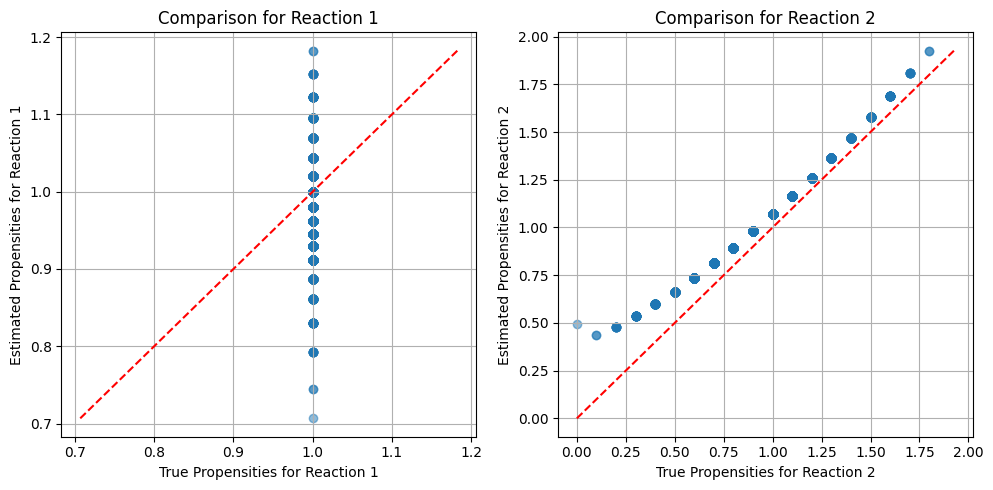

In [6]:
nn_predictions = custom_model.predict(y)

true_props = np.array([model_bd.getPropensities(obs, time) for obs, time in zip(y, t)])
true_props_unique = np.zeros(shape=(true_props.shape[0], num_unique_stoch))
for rct, rct_map in enumerate(unique_reaction_mapping):
    true_props_unique[:, rct_map] += true_props[:, rct]

fig = createPropensityPlot(nn_predictions, true_props_unique)
plt.savefig("bd_comparison.svg")

Lets compare it with the MLE 

/tmp/ipykernel_69815/1584653936.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


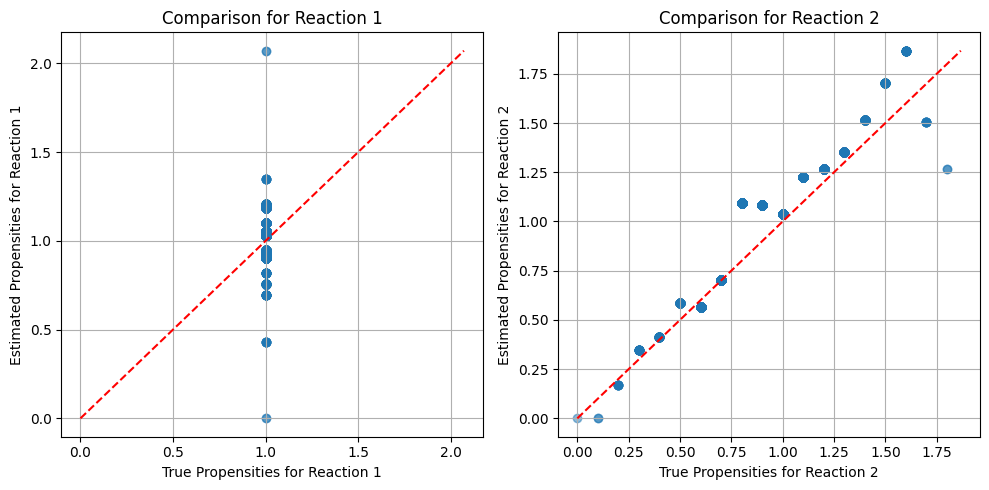

In [7]:
estimator = MLEstimator(model_bd, y, t)
mle_matrix = estimator.computeMLETransitionMatrix()
fig = estimator.plotMLEstimates(mle_matrix)
fig.show()
plt.savefig("bd_comparison_MLE.svg")

# NN for Lotka-Voltera Model

In [10]:
from src.Models.paper_examples import ThreeSpeciesModel
model_lv = ThreeSpeciesModel()
simulator_lv = SSASimulator(model_lv)

parameters = model_lv.getDefaultParameter()
x0 = model_lv.getDefaultInitialState()
y, t = simulator_lv.run_ssa(x0, 100, parameters)
num_states = y.shape[1]

In [11]:
reaction_indices, unique_reaction_mapping = getReactionsForObservations(y, model_lv.getStoichiometry())
num_unique_stoch = len(np.unique(unique_reaction_mapping))

custom_model = FeedForwardPropensityModel(num_inputs=num_states, num_outputs=num_unique_stoch, num_layers=6, num_neurons=256)
data_preparator = DataPreparatorFullObs()
data_preparator.addTrajectory(y, t, reaction_indices)

num_trajs = 10
for num_traj in range(num_trajs):
    y, t = simulator_lv.run_ssa(x0, 100, parameters)
    reaction_indices, unique_reaction_mapping = getReactionsForObservations(y, model_lv.getStoichiometry())
    data_preparator.addTrajectory(y, t, reaction_indices)

    

train_dataset = data_preparator.getTraindDataset()

In [12]:
custom_model.fit(train_dataset, epochs=200)

Epoch 1/200
178/178 [==============================] - 14s 65ms/step - loss: 12682.1367
Epoch 2/200
178/178 [==============================] - 13s 74ms/step - loss: -132.6206
Epoch 3/200
178/178 [==============================] - 14s 77ms/step - loss: -182.6194
Epoch 4/200
178/178 [==============================] - 15s 84ms/step - loss: -186.1854
Epoch 5/200
178/178 [==============================] - 15s 83ms/step - loss: -188.7094
Epoch 6/200
178/178 [==============================] - 15s 83ms/step - loss: -191.1604
Epoch 7/200
178/178 [==============================] - 15s 85ms/step - loss: -193.0835
Epoch 8/200
178/178 [==============================] - 15s 85ms/step - loss: -193.8222
Epoch 9/200
178/178 [==============================] - 16s 89ms/step - loss: -192.4102
Epoch 10/200
178/178 [==============================] - 16s 88ms/step - loss: -189.3115
Epoch 11/200
178/178 [==============================] - 16s 89ms/step - loss: 3533.1025
Epoch 12/200
178/178 [==================

KeyboardInterrupt: 

1019/1019 [==============================] - 2s 2ms/step
Mean Squared Error between NN predictions and expected propensities: 4.979222657662776


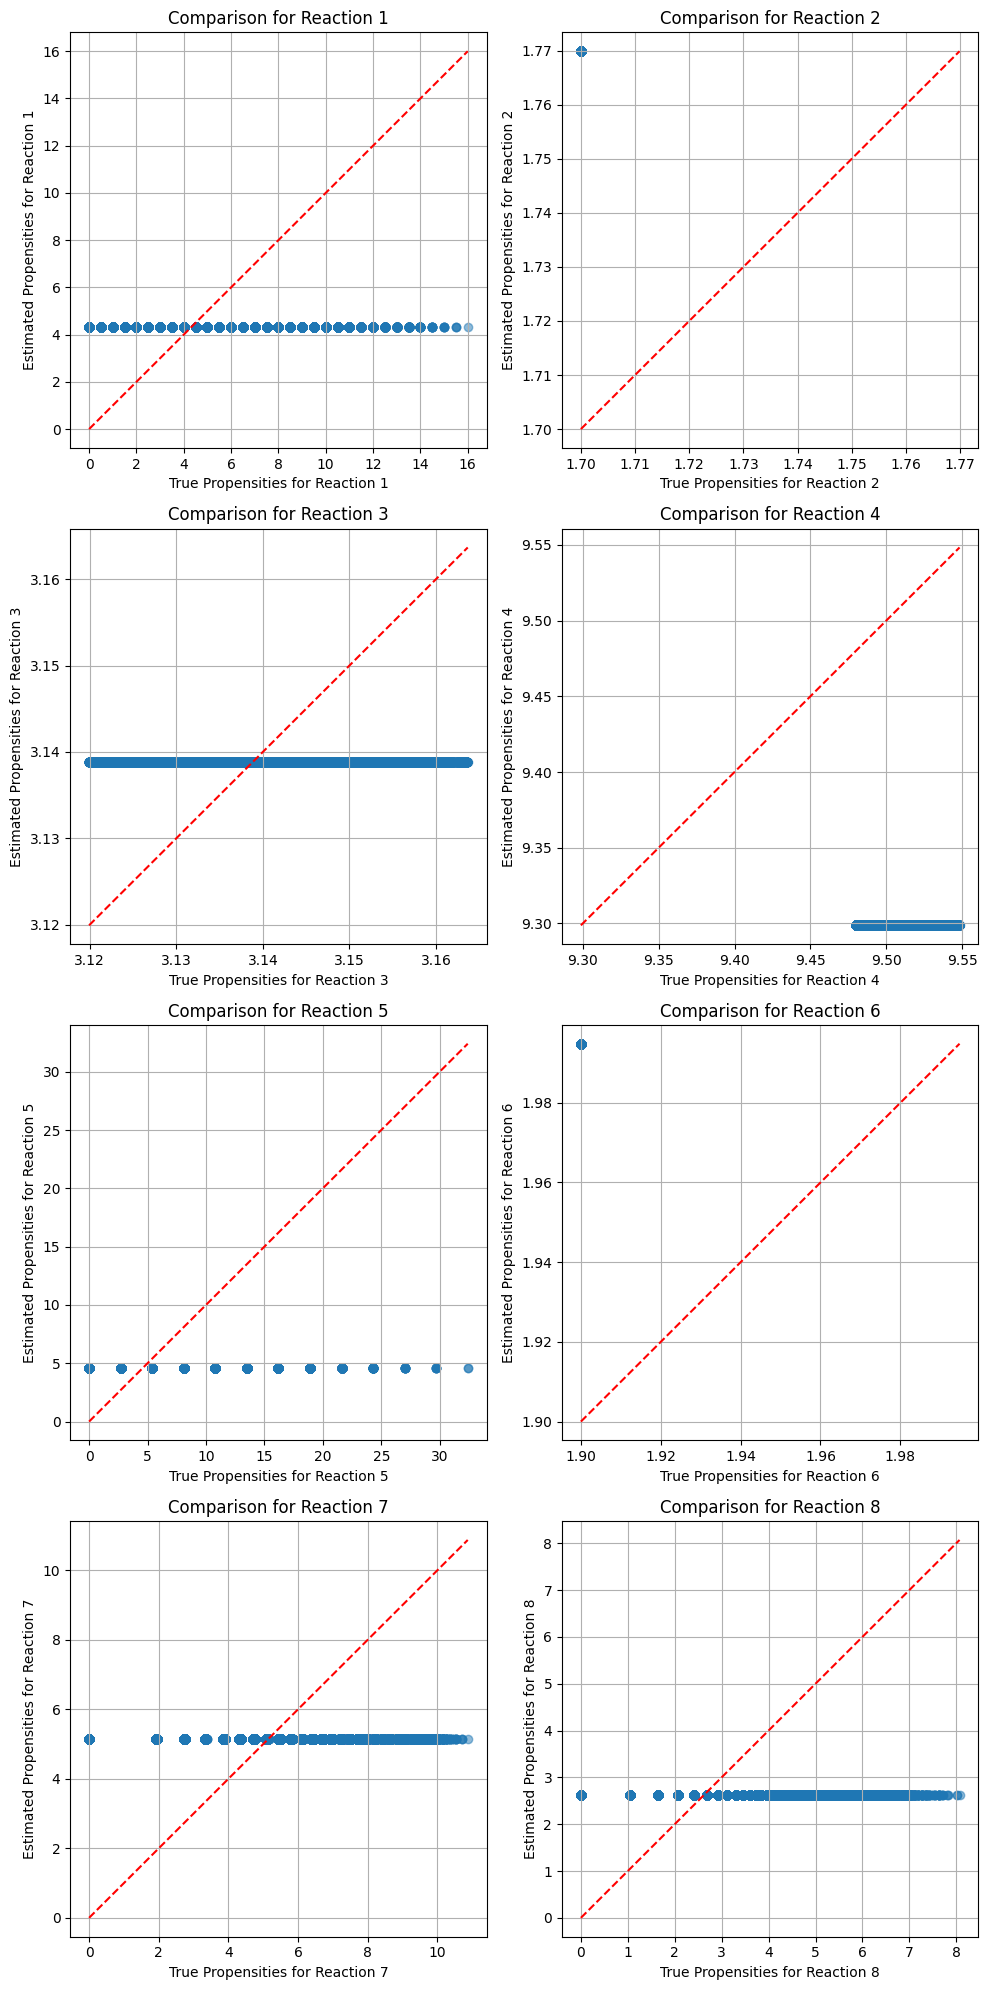

In [48]:
nn_predictions = custom_model.predict(y)

true_props = np.array([model_lv.getPropensities(obs, time) for obs, time in zip(y, t)])
true_props_unique = np.zeros(shape=(true_props.shape[0], num_unique_stoch))
for rct, rct_map in enumerate(unique_reaction_mapping):
    true_props_unique[:, rct_map] += true_props[:, rct]
fig = createPropensityPlot(nn_predictions, true_props_unique)

# NN for Chemical Reaction Network Model


In [20]:
from src.Models.paper_examples import ChemicalReactionNetwork
model_crn = ChemicalReactionNetwork()
simulator_crn = SSASimulator(model_crn)

parameters = model_crn.getDefaultParameter()
x0 = model_crn.getDefaultInitialState()
y, t = simulator_crn.run_ssa(x0, 10000, parameters)
num_states = y.shape[1]

In [21]:
reaction_indices, unique_reaction_mapping = getReactionsForObservations(y, model_crn.getStoichiometry())
num_unique_stoch = len(np.unique(unique_reaction_mapping))

custom_model = FeedForwardPropensityModel(num_inputs=num_states, num_outputs=num_unique_stoch, num_layers=4)
data_preparator = DataPreparatorFullObs()
data_preparator.addTrajectory(y, t, reaction_indices)
train_dataset = data_preparator.getTraindDataset()

In [22]:
custom_model.fit(train_dataset, epochs=200)

Epoch 1/200
5/5 [==============================] - 3s 100ms/step - loss: 3454.0417
Epoch 2/200
5/5 [==============================] - 0s 97ms/step - loss: 2349.3857
Epoch 3/200
5/5 [==============================] - 0s 94ms/step - loss: 2363.5127
Epoch 4/200
5/5 [==============================] - 0s 94ms/step - loss: 2217.9226
Epoch 5/200
5/5 [==============================] - 1s 109ms/step - loss: 2031.4518
Epoch 6/200
5/5 [==============================] - 1s 99ms/step - loss: 1954.3684
Epoch 7/200
5/5 [==============================] - 1s 102ms/step - loss: 1915.4304
Epoch 8/200
5/5 [==============================] - 0s 90ms/step - loss: 1856.0748
Epoch 9/200
5/5 [==============================] - 0s 97ms/step - loss: 1832.7510
Epoch 10/200
5/5 [==============================] - 1s 99ms/step - loss: 1805.2074
Epoch 11/200
5/5 [==============================] - 0s 91ms/step - loss: 1792.4410
Epoch 12/200
5/5 [==============================] - 0s 97ms/step - loss: 1780.5358
Epoch 13/2

79/79 [==============================] - 0s 2ms/step


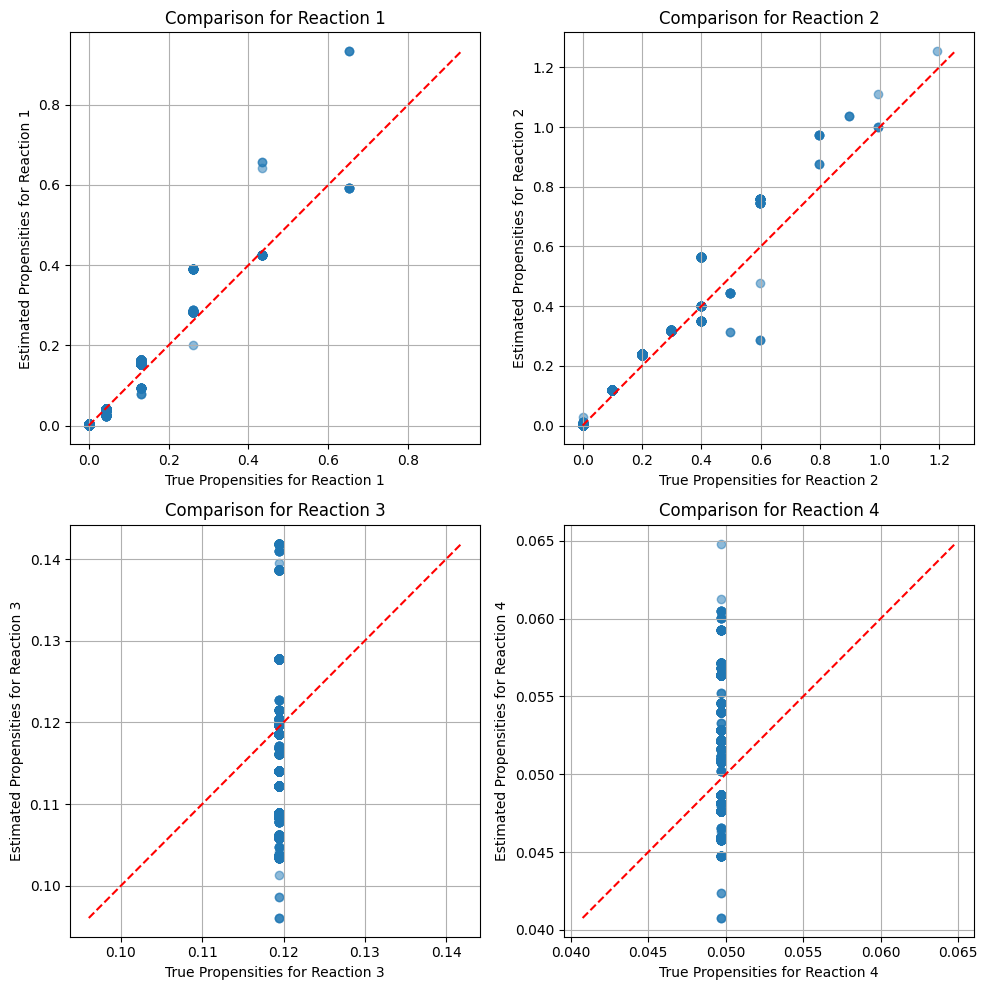

In [23]:
nn_predictions = custom_model.predict(y)

true_props = np.array([model_crn.getPropensities(obs, time) for obs, time in zip(y, t)])
true_props_unique = np.zeros(shape=(true_props.shape[0], num_unique_stoch))
for rct, rct_map in enumerate(unique_reaction_mapping):
    true_props_unique[:, rct_map] += true_props[:, rct]

fig = createPropensityPlot(nn_predictions, true_props_unique)

Compare with MLE

/tmp/ipykernel_18643/13457184.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


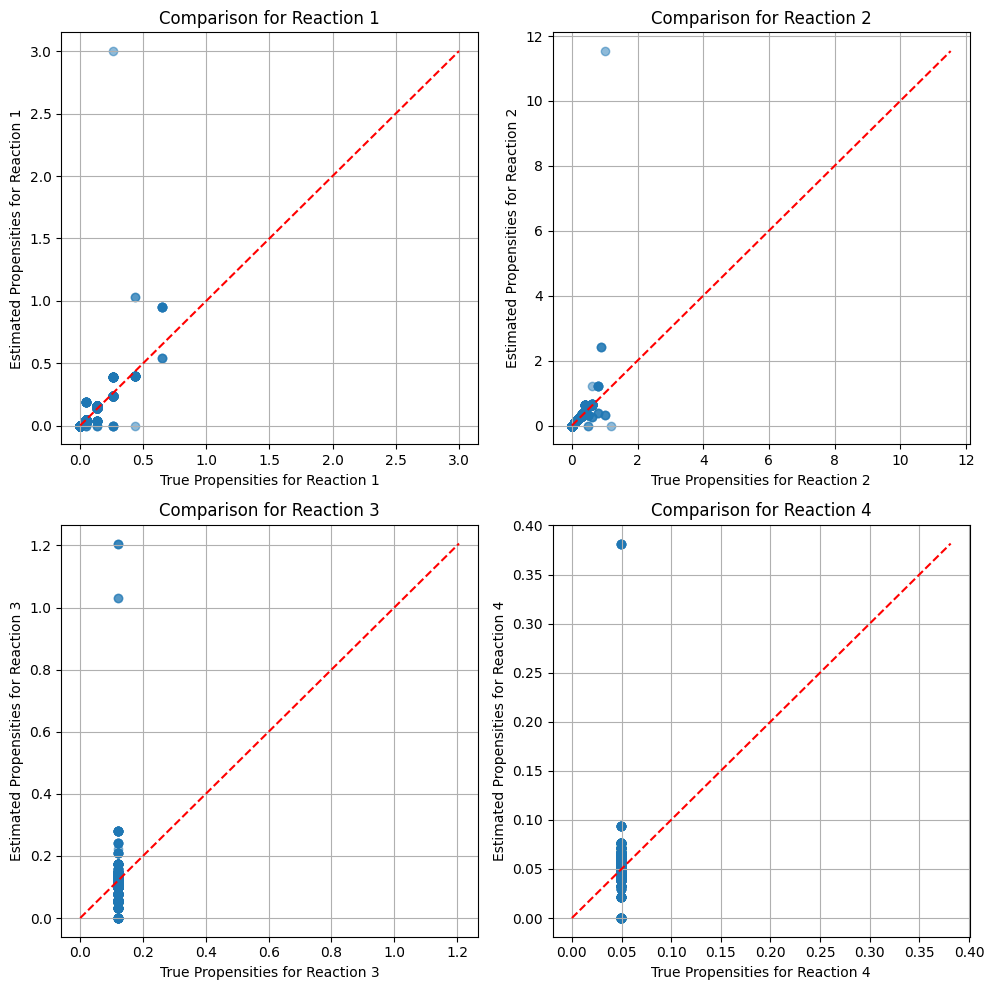

In [24]:
estimator = MLEstimator(model_crn, y, t)
mle_matrix = estimator.computeMLETransitionMatrix()
fig = estimator.plotMLEstimates(mle_matrix)
fig.show()

# Lac-Gfp Model


In [8]:
from src.Models.example_networks import LacGfp
model_lac = LacGfp()
simulator_lac = SSASimulator(model_lac)

parameters = model_lac.getDefaultParameter()
x0 = model_lac.getDefaultInitialState()
y, t = simulator_lac.run_ssa(x0, 10, parameters)
num_states = y.shape[1]

In [10]:
reaction_indices, unique_reaction_mapping = getReactionsForObservations(y, model_lac.getStoichiometry())
num_unique_stoch = len(np.unique(unique_reaction_mapping))

custom_model = FeedForwardPropensityModel(num_inputs=num_states, num_outputs=num_unique_stoch, num_layers=4)
data_preparator = DataPreparatorFullObs(batch_size=1024)
data_preparator.addTrajectory(y, t, reaction_indices)

num_trajs = 50
for num_traj in range(num_trajs -1):
    y, t = simulator_lac.run_ssa(x0, 10, parameters)
    reaction_indices, unique_reaction_mapping = getReactionsForObservations(y, model_lac.getStoichiometry())
    data_preparator.addTrajectory(y, t, reaction_indices)
    
train_dataset = data_preparator.getTraindDataset()

In [ ]:
custom_model.fit(train_dataset, epochs=20)

Epoch 1/20
237/237 [==============================] - 56s 228ms/step - loss: -4712.2842
Epoch 2/20
237/237 [==============================] - 60s 252ms/step - loss: -5044.7710
Epoch 3/20
237/237 [==============================] - 60s 255ms/step - loss: -5098.7114
Epoch 4/20
237/237 [==============================] - 62s 261ms/step - loss: -5147.8330
Epoch 5/20
237/237 [==============================] - 83s 350ms/step - loss: -5088.8560
Epoch 6/20
237/237 [==============================] - 56s 237ms/step - loss: -5254.4585
Epoch 7/20
237/237 [==============================] - 51s 215ms/step - loss: -5278.5527
Epoch 8/20
237/237 [==============================] - 56s 234ms/step - loss: -5303.3203
Epoch 9/20
237/237 [==============================] - 54s 226ms/step - loss: -5311.7705
Epoch 10/20
166/237 [====================>.........] - ETA: 19s - loss: -5471.4795

In [ ]:
nn_predictions = custom_model.predict(y)

true_props = np.array([model_lac.getPropensities(obs, time) for obs, time in zip(y, t)])
true_props_unique = np.zeros(shape=(true_props.shape[0], num_unique_stoch))
for rct, rct_map in enumerate(unique_reaction_mapping):
    true_props_unique[:, rct_map] += true_props[:, rct]

fig = createPropensityPlot(nn_predictions, true_props_unique)